In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


let's look at behavior of variance estimation and eigval estimation for K = 2..10


cases:
- trials L = 5, 10, 15, 20, 25
- complex gaussian / real gaussian
- rank 1, rank 2, ... full rank


In [3]:
import os
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.jax.dists import sample_from_gamma, sample_obs, sample_ccn_rank1
# from cohlib.jax.observations import add0
# from cohlib.jax.simtools import load_gamma, construct_gamma_init

from cohlib.utils import pickle_open

In [13]:
from cohlib.utils import gamma_root
def test_rank1_ccn(N, L, gamma_name, seed_start):
    print(f"N = {N}, L = {L}, gamma = {gamma_name}")
    gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pkl")
    gamma_load = pickle_open(gamma_path)
    gamma_full = gamma_load['gamma']
    K = gamma_full.shape[-1]
    eigvec = gamma_load['eigvec']
    eigval = gamma_load['eigval']

    nz_target = gamma_load['target_inds']
    gamma_true = gamma_full[nz_target,:,:].squeeze()


    gamma_ests = jnp.zeros((N,K,K), dtype=complex)
    for n in range(N):
        seed = seed_start + n 
        lrk = jr.key(seed)

        zs = sample_ccn_rank1(lrk, eigvec, eigval, K, L)
        gamma_oracle = jnp.einsum('kl,il->kil', zs, zs.conj()).mean(-1)
        gamma_ests = gamma_ests.at[n,:,:].set(gamma_oracle)
    
    return gamma_ests, gamma_true



N = 25, L = 10, gamma = k3-log-chlg3-rank1-nz9
N = 25, L = 50, gamma = k3-log-chlg3-rank1-nz9
N = 25, L = 100, gamma = k3-log-chlg3-rank1-nz9


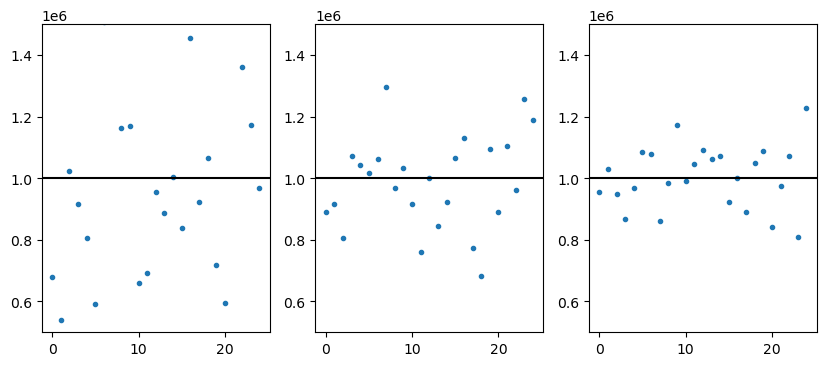

In [5]:
L = 10
fig, ax = plt.subplots(1, 3, figsize=(10,4))
L_count = 0 
for i, L in enumerate([10, 50, 100]):
    loc = i
    K = 3
    gamma_name = f'k{K}-log-chlg3-rank1-nz9'
    N = 25

    gamma_ests, gamma_true = test_rank1_ccn(N, L, gamma_name, seed_start=L_count)

    k = 0
    m, n = k, k

    def func(gamma, params):
        i = params['i']
        j = params['j']
        return gamma[i,j].real

    params = {'i': k, 'j': k}

    y_hw = 5e5

    est_reps = jnp.array([func(gamma_ests[n,:,:], params) for n in range(N)])
    ax[loc].plot(est_reps, '.')
    true_val = func(gamma_true, params)
    ax[loc].axhline(true_val, color='k')
    ax[loc].set_ylim([true_val - y_hw, true_val + y_hw])
    L_count += L


In [6]:
Ls = jnp.array([10, 50, 100])
[str(L) for L in Ls]

['10', '50', '100']

In [7]:
jnp.repeat(5,3)

Array([5, 5, 5], dtype=int32, weak_type=True)

N = 50, L = 10, gamma = k3-log-chlg3-rank1-nz9
N = 50, L = 50, gamma = k3-log-chlg3-rank1-nz9
N = 50, L = 100, gamma = k3-log-chlg3-rank1-nz9


Text(0.5, 1.0, '')

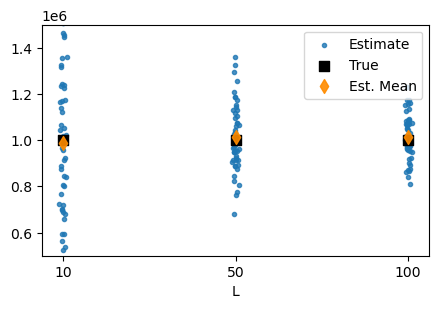

In [8]:
def func(gamma, params):
    i = params['i']
    j = params['j']
    return gamma[i,j].real

params = {'i': k, 'j': k}

Ls = jnp.array([10, 50, 100])
xvals = jnp.arange(Ls.size)
xlabels = [str(L) for L in Ls]

K = 3
N = 50
fig, ax = plt.subplots(figsize=(5,3))
L_count = 0
for i, L in enumerate(Ls):
    gamma_name = f'k{K}-log-chlg3-rank1-nz9'
    gamma_ests, gamma_true = test_rank1_ccn(N, L, gamma_name, seed_start = L_count)
    L_count += L

    y_hw = 5e5

    est_reps = jnp.array([func(gamma_ests[n,:,:], params) for n in range(N)])
    true_val = func(gamma_true, params)


    xval = xvals[i]
    xreps = jnp.repeat(xval, N) + jnp.sqrt(1e-4)*jr.normal(jr.key(7), (N,))

    ax.scatter(xreps, est_reps, marker='.', color='tab:blue', alpha = 0.8, label='Estimate')
    ax.scatter(xval, true_val, color='k', marker='s', s=50, label='True')
    ax.scatter(xval, est_reps.mean(), color='darkorange', marker='d', s=50, label='Est. Mean', alpha=0.9)
    if i == 0:
        ax.legend()

ax.set_ylim([true_val - y_hw, true_val + y_hw])
ax.set_xticks(xvals)
ax.set_xticklabels(xlabels)
ax.set_xlabel('L')
ax.set_title('')


N = 50, L = 10, gamma = k3-log-chlg3-rank1-nz9
N = 50, L = 50, gamma = k3-log-chlg3-rank1-nz9
N = 50, L = 100, gamma = k3-log-chlg3-rank1-nz9
N = 50, L = 10, gamma = k10-log-chlg3-rank1-nz9
N = 50, L = 50, gamma = k10-log-chlg3-rank1-nz9
N = 50, L = 100, gamma = k10-log-chlg3-rank1-nz9
N = 50, L = 10, gamma = k25-log-chlg3-rank1-nz9
N = 50, L = 50, gamma = k25-log-chlg3-rank1-nz9
N = 50, L = 100, gamma = k25-log-chlg3-rank1-nz9


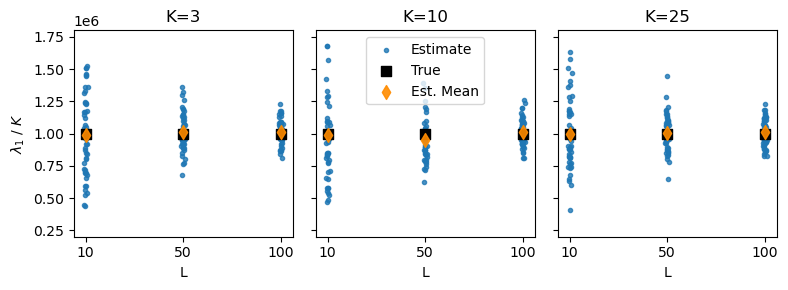

In [9]:
def func(gamma, params):
    rank = params['rank']
    evs, _ = jnp.linalg.eigh(gamma)
    return evs[-rank]

rank = 1
params = {'rank': rank}

Ls = jnp.array([10, 50, 100])
xvals = jnp.arange(Ls.size)
xlabels = [str(L) for L in Ls]

y_hw = 8e5
yfree = False

N = 50
Ks = [3, 10, 25]
fig, axs = plt.subplots(1, len(Ks), figsize=(8,3), sharey=True)
for i, K in enumerate(Ks):

    ax = axs[i]
    L_count = 0
    for j, L in enumerate(Ls):
        gamma_name = f'k{K}-log-chlg3-rank1-nz9'
        gamma_ests, gamma_true = test_rank1_ccn(N, L, gamma_name, seed_start = L_count)
        L_count += L

        est_reps = jnp.array([func(gamma_ests[n,:,:], params) for n in range(N)])
        true_val = func(gamma_true, params)


        xval = xvals[j]
        xreps = jnp.repeat(xval, N) + jnp.sqrt(1e-4)*jr.normal(jr.key(7), (N,))

        ax.scatter(xreps, est_reps/K, marker='.', color='tab:blue', alpha = 0.8, label='Estimate')
        ax.scatter(xval, true_val/K, color='k', marker='s', s=50, label='True')
        ax.scatter(xval, est_reps.mean()/K, color='darkorange', marker='d', s=50, label='Est. Mean', alpha=0.9)
        if i == 1 and j == 0:
            ax.legend()
        if i == 0:
            ax.set_ylabel(f'$\lambda_{rank}$ / $K$')

    ax.set_ylim([true_val/K - y_hw, true_val/K + y_hw])
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('L')
    ax.set_title(f'K={K}')
plt.tight_layout()

N = 1000, L = 10, gamma = k3-log-chlg3-rank1-nz9
N = 1000, L = 50, gamma = k3-log-chlg3-rank1-nz9
N = 1000, L = 100, gamma = k3-log-chlg3-rank1-nz9
N = 1000, L = 10, gamma = k10-log-chlg3-rank1-nz9
N = 1000, L = 50, gamma = k10-log-chlg3-rank1-nz9
N = 1000, L = 100, gamma = k10-log-chlg3-rank1-nz9
N = 1000, L = 10, gamma = k25-log-chlg3-rank1-nz9
N = 1000, L = 50, gamma = k25-log-chlg3-rank1-nz9
N = 1000, L = 100, gamma = k25-log-chlg3-rank1-nz9


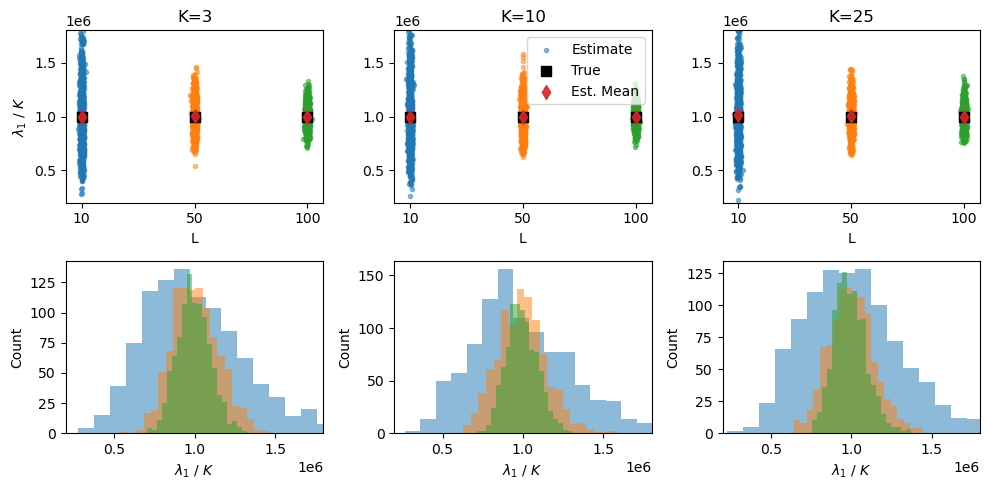

In [10]:
def func(gamma, params):
    rank = params['rank']
    evs, _ = jnp.linalg.eigh(gamma)
    return evs[-rank]

rank = 1
params = {'rank': rank}

Ls = jnp.array([10, 50, 100])
xvals = jnp.arange(Ls.size)
xlabels = [str(L) for L in Ls]

y_hw = 8e5
yfree = False

colors = ['tab:blue', 'tab:orange', 'tab:green']

N = 1000
Ks = [3, 10, 25]
fig, axs = plt.subplots(2, len(Ks), figsize=(10,5))

for k, K in enumerate(Ks):
    L_count = 0
    for j, L in enumerate(Ls):
        gamma_name = f'k{K}-log-chlg3-rank1-nz9'
        gamma_ests, gamma_true = test_rank1_ccn(N, L, gamma_name, seed_start = L_count)
        L_count += L

        est_reps = jnp.array([func(gamma_ests[n,:,:], params) for n in range(N)])
        true_val = func(gamma_true, params)


        xval = xvals[j]
        xreps = jnp.repeat(xval, N) + jnp.sqrt(1e-4)*jr.normal(jr.key(7), (N,))

        ax = axs[0,k]
        ax.scatter(xreps, est_reps/K, marker='.', color=colors[j], alpha = 0.5, label='Estimate')
        ax.scatter(xval, true_val/K, color='k', marker='s', s=50, label='True')
        ax.scatter(xval, est_reps.mean()/K, color='tab:red', marker='d', s=50, label='Est. Mean', alpha=0.9)
        if k == 1 and j == 0:
            ax.legend()
        if k == 0:
            ax.set_ylabel(f'$\lambda_{rank}$ / $K$')

        ax.set_ylim([true_val/K - y_hw, true_val/K + y_hw])
        ax.set_xticks(xvals)
        ax.set_xticklabels(xlabels)
        ax.set_xlabel('L')
        ax.set_title(f'K={K}')

        ax = axs[1,k]
        ax.hist(est_reps/K, color=colors[j], bins=20, alpha=0.5)
        ax.set_xlim([true_val/K - y_hw, true_val/K + y_hw])
        # ax.scatter(xval, true_val/K, color='k', marker='s', s=50, label='True')
        # ax.scatter(xval, est_reps.mean()/K, color='darkorange', marker='d', s=50, label='Est. Mean', alpha=0.9)
        ax.set_xlabel(f'$\lambda_{rank}$ / $K$')
        ax.set_ylabel('Count')

    # ax.set_ylim([true_val - y_hw, true_val + y_hw])
plt.tight_layout()

In [ ]:
def test_rank1_ccn_r1m(N, L, gamma_name, seed_start):
    print(f"N = {N}, L = {L}, gamma = {gamma_name}")
    gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pkl")
    gamma_load = pickle_open(gamma_path)
    gamma_full = gamma_load['gamma']
    K = gamma_full.shape[-1]
    eigvec = gamma_load['eigvec']
    eigval = gamma_load['eigval']

    nz_target = gamma_load['target_inds']
    gamma_true = gamma_full[nz_target,:,:].squeeze()


    gamma_ests = jnp.zeros((N,K,K), dtype=complex)
    for n in range(N):
        seed = seed_start + n 
        lrk = jr.key(seed)

        zs = sample_ccn_rank1(lrk, eigvec, eigval, K, L)

        uuH = jnp.outer(eigvec, eigvec.conj())
        quadsum = jnp.einsum('jl,jk,kl->l', zs.conj(), uuH, zs).sum()
        gamma_ests = gamma_ests.at[n,:,:].set(quadsum/L)
    
    return gamma_ests, gamma_true


N = 1000, L = 10, gamma = k3-log-chlg3-rank1-nz9
N = 1000, L = 50, gamma = k3-log-chlg3-rank1-nz9
N = 1000, L = 100, gamma = k3-log-chlg3-rank1-nz9
N = 1000, L = 10, gamma = k10-log-chlg3-rank1-nz9
N = 1000, L = 50, gamma = k10-log-chlg3-rank1-nz9
N = 1000, L = 100, gamma = k10-log-chlg3-rank1-nz9
N = 1000, L = 10, gamma = k25-log-chlg3-rank1-nz9
N = 1000, L = 50, gamma = k25-log-chlg3-rank1-nz9
N = 1000, L = 100, gamma = k25-log-chlg3-rank1-nz9


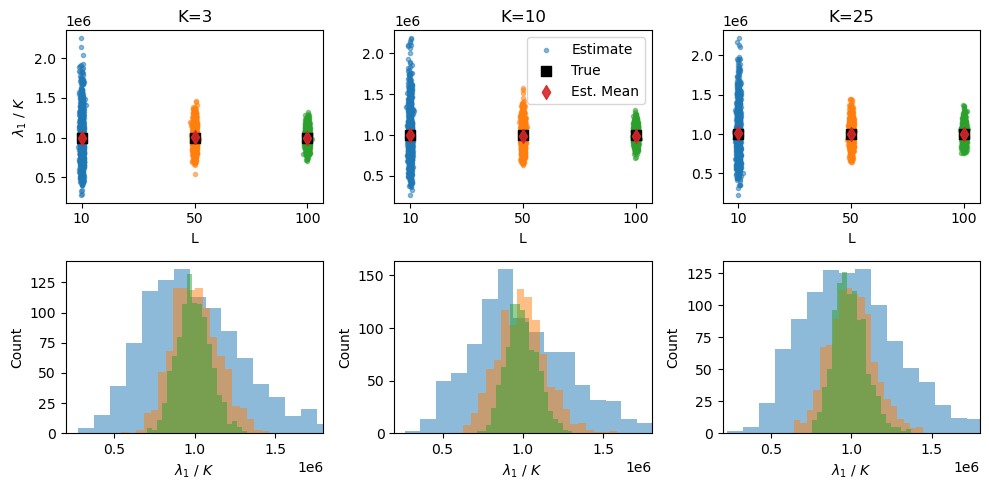

In [17]:
def func(gamma, params):
    eigvec = params['eigvec']
    uuH = jnp.outer(eigvec, eigvec.conj())
    ev1_est = jnp.trace(uuH @ gamma).real
    return ev1_est

rank = 1

Ls = jnp.array([10, 50, 100])
xvals = jnp.arange(Ls.size)
xlabels = [str(L) for L in Ls]

y_hw = 8e5
yfree = False

colors = ['tab:blue', 'tab:orange', 'tab:green']

N = 1000
Ks = [3, 10, 25]
fig, axs = plt.subplots(2, len(Ks), figsize=(10,5))

for k, K in enumerate(Ks):
    L_count = 0
    for j, L in enumerate(Ls):

        gamma_name = f'k{K}-log-chlg3-rank1-nz9'
        gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pkl")
        gamma_load = pickle_open(gamma_path)
        eigvec = gamma_load['eigvec']
        params = {'eigvec': eigvec}
        gamma_ests, gamma_true = test_rank1_ccn(N, L, gamma_name, seed_start = L_count)
        L_count += L

        est_reps = jnp.array([func(gamma_ests[n,:,:], params) for n in range(N)])
        true_val = func(gamma_true, params)


        xval = xvals[j]
        xreps = jnp.repeat(xval, N) + jnp.sqrt(1e-4)*jr.normal(jr.key(7), (N,))

        ax = axs[0,k]
        ax.scatter(xreps, est_reps/K, marker='.', color=colors[j], alpha = 0.5, label='Estimate')
        ax.scatter(xval, true_val/K, color='k', marker='s', s=50, label='True')
        ax.scatter(xval, est_reps.mean()/K, color='tab:red', marker='d', s=50, label='Est. Mean', alpha=0.9)
        if k == 1 and j == 0:
            ax.legend()
        if k == 0:
            ax.set_ylabel(f'$\lambda_{rank}$ / $K$')

        # ax.set_ylim([true_val/K - y_hw, true_val/K + y_hw])
        ax.set_xticks(xvals)
        ax.set_xticklabels(xlabels)
        ax.set_xlabel('L')
        ax.set_title(f'K={K}')

        ax = axs[1,k]
        ax.hist(est_reps/K, color=colors[j], bins=20, alpha=0.5)
        ax.set_xlim([true_val/K - y_hw, true_val/K + y_hw])
        # ax.scatter(xval, true_val/K, color='k', marker='s', s=50, label='True')
        # ax.scatter(xval, est_reps.mean()/K, color='darkorange', marker='d', s=50, label='Est. Mean', alpha=0.9)
        ax.set_xlabel(f'$\lambda_{rank}$ / $K$')
        ax.set_ylabel('Count')

    # ax.set_ylim([true_val - y_hw, true_val + y_hw])
plt.tight_layout()

(array([ 10.,  17.,  36.,  50.,  96., 117., 126., 109., 111.,  88.,  89.,
         46.,  38.,  29.,  15.,   8.,   5.,   5.,   2.,   3.]),
 array([ 755414.5   ,  786220.75  ,  817027.0625,  847833.375 ,
         878639.625 ,  909445.875 ,  940252.1875,  971058.5   ,
        1001864.75  , 1032671.    , 1063477.25  , 1094283.625 ,
        1125089.875 , 1155896.125 , 1186702.5   , 1217508.75  ,
        1248315.    , 1279121.25  , 1309927.5   , 1340733.875 ,
        1371540.125 ]),
 <BarContainer object of 20 artists>)

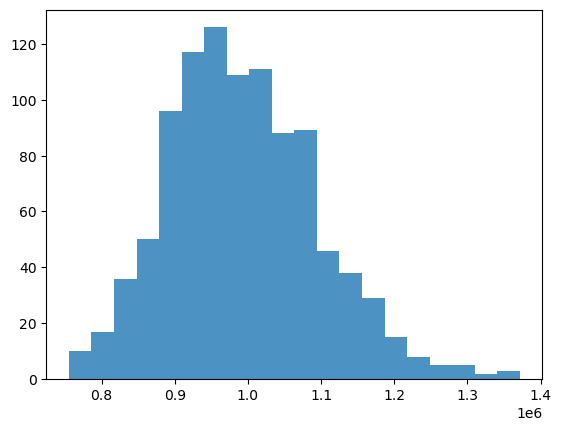

In [11]:
plt.hist(est_reps/K, bins=20, alpha=0.8)

In [12]:
true_val / 1e6

Array(25.000004, dtype=float32)